# Finding more Alpha Factors

In [5]:
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
from quantopian.pipeline.filters.morningstar import Q1500US
from quantopian.pipeline.data.sentdex import sentiment
from quantopian.pipeline.data.morningstar import operation_ratios

def make_pipeline():
    # try many types i.e.
    # Yes: operation_ratios.revenue_growth.latest, operation_ratios.operation_margin, sentiment
    testing_factor1 = operation_ratios.operation_margin.latest
    testing_factor2 = operation_ratios.revenue_growth.latest
    testing_factor3 = sentiment.sentiment_signal.latest
    
    universe = (Q1500US() &
                testing_factor1.notnull() &
                testing_factor2.notnull() &
                testing_factor3.notnull())
    
    testing_factor1 = testing_factor1.rank(mask=universe, method='average')
    testing_factor2 = testing_factor2.rank(mask=universe, method='average')
    testing_factor3 = testing_factor3.rank(mask=universe, method='average')
    
    testing_factor = testing_factor1 + testing_factor2 + testing_factor3
    
    testing_quantiles = testing_factor.quantiles(2)
    
    pipe = Pipeline(columns={
        'testing_factor':testing_factor,
        'shorts':testing_quantiles.eq(0),
        'longs':testing_quantiles.eq(1)},
                    
                   screen=universe)
    
    return pipe

result = run_pipeline(make_pipeline(), start_date='2015-01-01', end_date='2016-01-01')
result.head()

longs shorts  testing_factor
2015-01-02 00:00:00+00:00 Equity(2 [ARNC])    True  False           782.0
                          Equity(24 [AAPL])   True  False          1171.0
                          Equity(62 [ABT])   False   True           774.5
                          Equity(67 [ADSK])   True  False           934.0
                          Equity(76 [TAP])   False   True           174.5

In [6]:
assets = result.index.levels[1].unique()
pricing = get_pricing(assets, start_date='2014-12-01', end_date='2016-02-01', fields='open_price')
len(assets)

9657

In [7]:
import alphalens


factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor=result['testing_factor'],
                                                                   prices = pricing,
                                                                   quantiles = 2,
                                                                   periods = (3,10,30)
                                                                  )
factor_data.head()

Dropped 4.7% entries from factor data: 4.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


3D       10D       30D  \
date                      asset                                             
2015-01-02 00:00:00+00:00 Equity(2 [ARNC])  -0.037179 -0.057359 -0.000127   
                          Equity(24 [AAPL]) -0.037617 -0.039142  0.149054   
                          Equity(62 [ABT])  -0.011492 -0.026912  0.023074   
                          Equity(67 [ADSK]) -0.037962 -0.074426  0.008658   
                          Equity(76 [TAP])  -0.008582 -0.005899 -0.022378   

                                             factor  factor_quantile  
date                      asset                                       
2015-01-02 00:00:00+00:00 Equity(2 [ARNC])    782.0                2  
                          Equity(24 [AAPL])  1171.0                2  
                          Equity(62 [ABT])    774.5                1  
                          Equity(67 [ADSK])   934.0                2  
                          Equity(76 [TAP])    174.5                1

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,47.0,797.5,540.979920,166.312105,61155,50.099536
2,744.0,1523.0,983.000205,147.989190,60912,49.900464


Returns Analysis


,3D,10D,30D
Ann. alpha,0.120,0.108,0.095
beta,-0.130,-0.165,-0.220
Mean Period Wise Return Top Quantile (bps),9.845,9.098,8.895
Mean Period Wise Return Bottom Quantile (bps),-9.798,-9.075,-8.930
Mean Period Wise Spread (bps),19.643,18.174,17.826


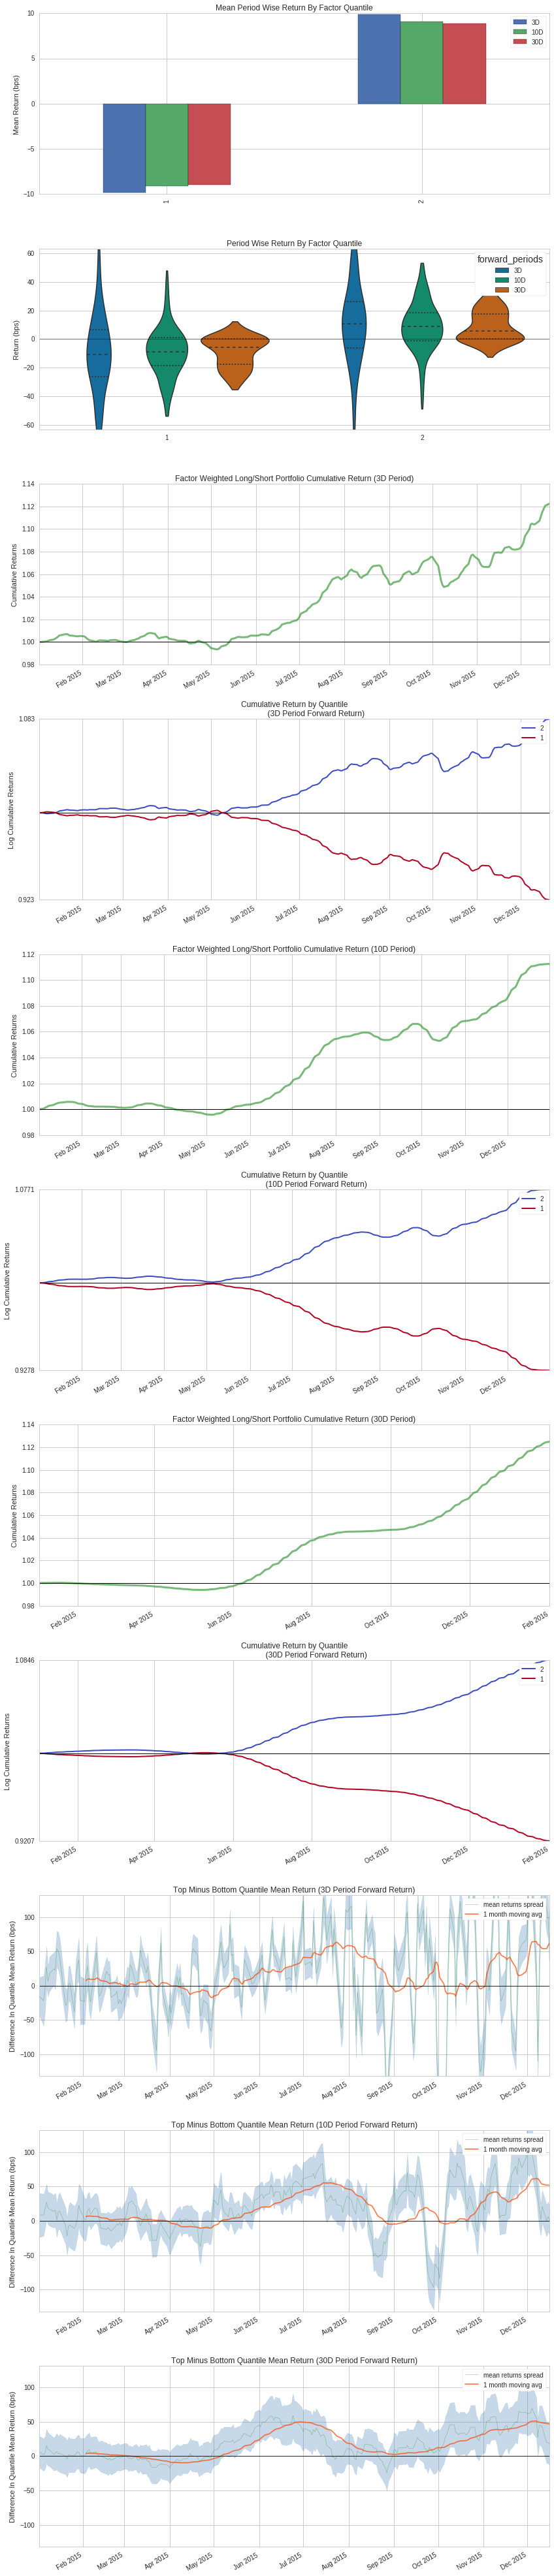

Information Analysis


,3D,10D,30D
IC Mean,0.045,0.070,0.102
IC Std.,0.138,0.127,0.127
Risk-Adjusted IC,0.329,0.553,0.804
t-stat(IC),5.116,8.607,12.515
p-value(IC),0.000,0.000,0.000
IC Skew,-0.201,-0.202,0.203
IC Kurtosis,-0.013,-0.390,-1.082


/venvs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


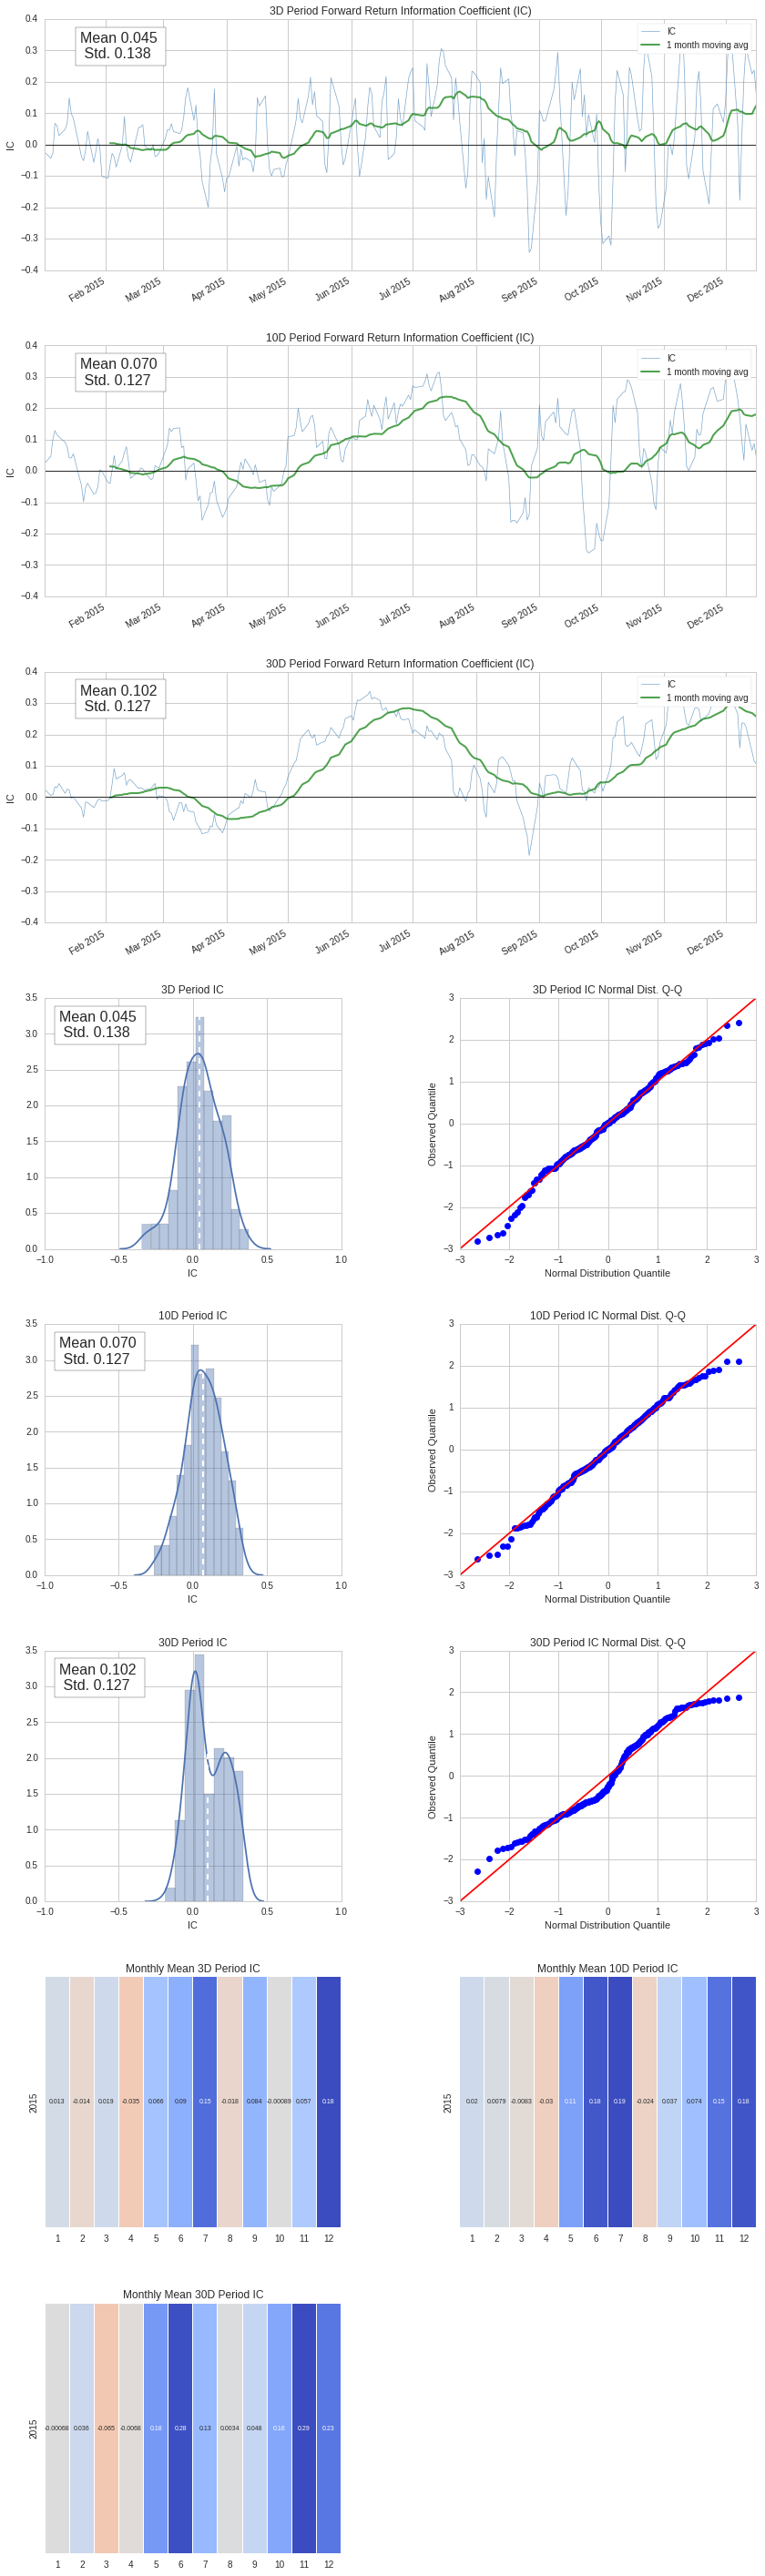

Turnover Analysis


,10D,30D,3D
Quantile 1 Mean Turnover,0.126,0.203,0.068
Quantile 2 Mean Turnover,0.125,0.200,0.068


,3D,10D,30D
Mean Factor Rank Autocorrelation,0.932,0.861,0.732


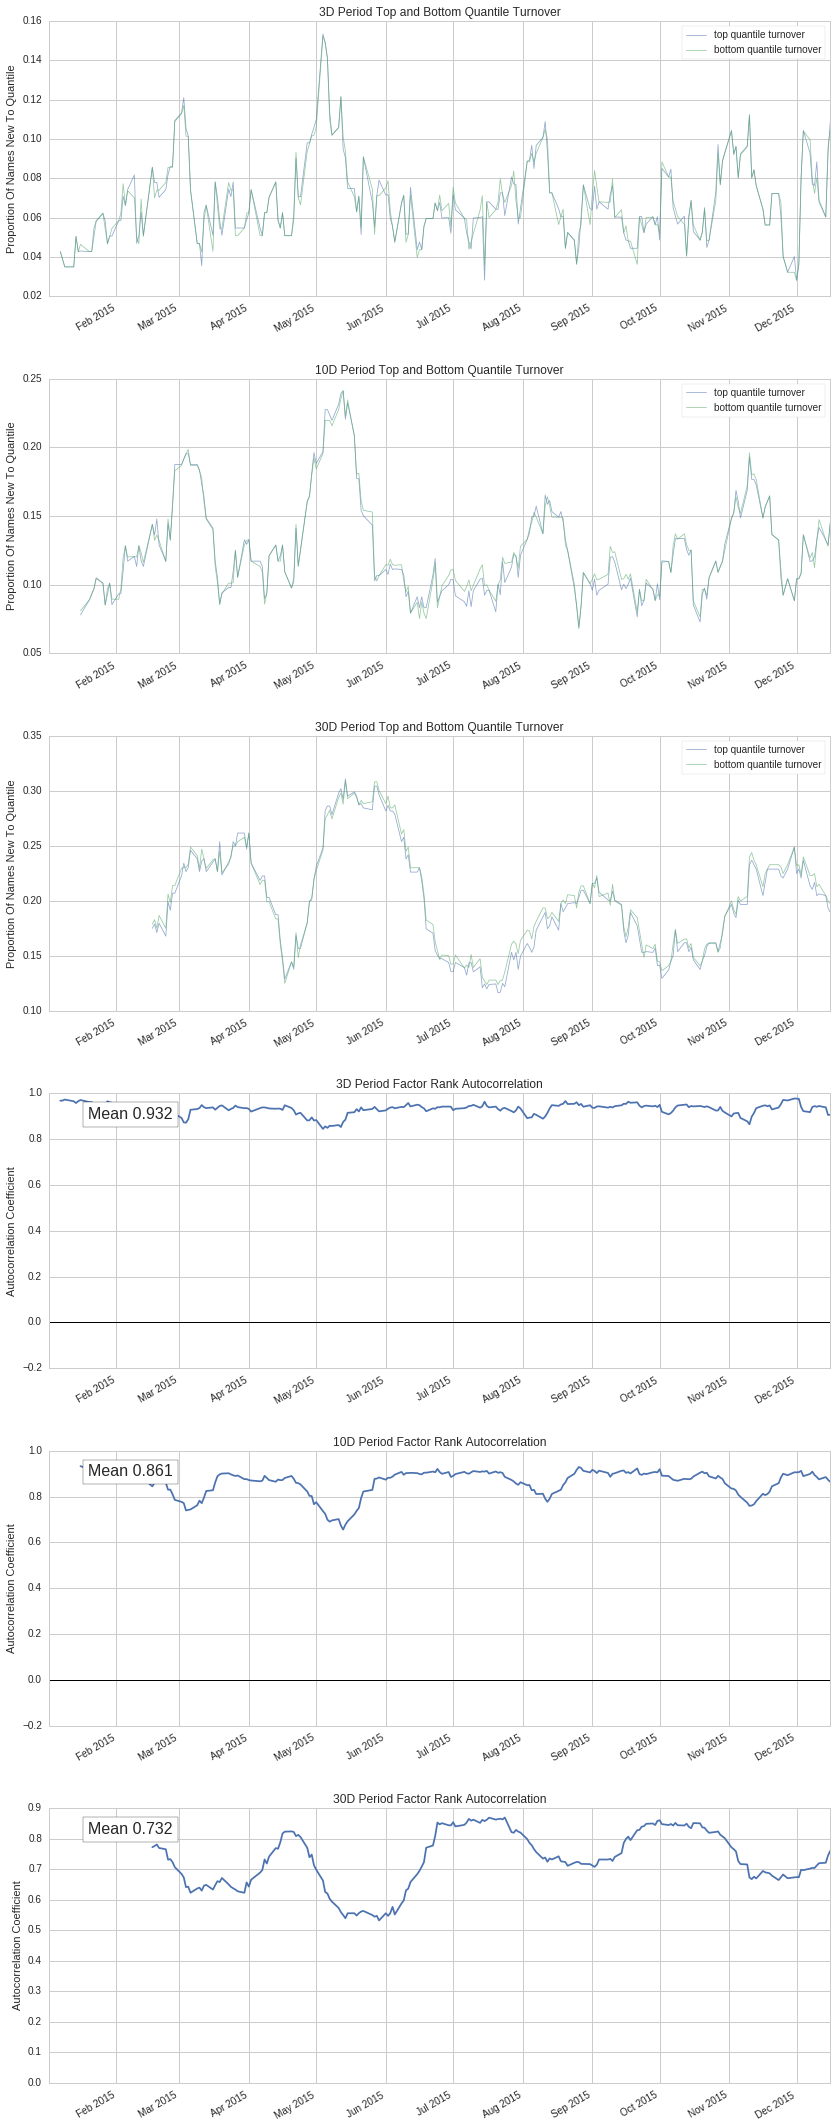

In [8]:
alphalens.tears.create_full_tear_sheet(factor_data)